# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [13]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
from __future__ import print_function
%matplotlib inline

In [14]:
ls /home/ch/data/

full_CNN_label.p  full_CNN_train.p


This image is: <type 'numpy.ndarray'> with dimesions: (80, 160, 3)


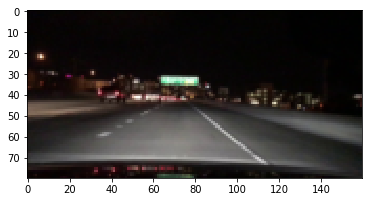

In [15]:
#reading in an image
img_path = '/home/ch/data/full_CNN_train.p'
label_path = '/home/ch/data/full_CNN_label.p'
with open(img_path, 'r') as f:
    imgs = pickle.load(f)
with open(label_path, 'r') as f:
    labels = pickle.load(f)
    
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = imgs[10]
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [16]:
labels[0].shape

(80, 160, 1)

In [17]:
def show_lane(img, label):
    shapes = img.shape
    for i in range(shapes[0]):
        for j in range(shapes[1]):
            if label[i][j]:
                pass
            else:
                img[i][j] = [0,0,0]
    return img


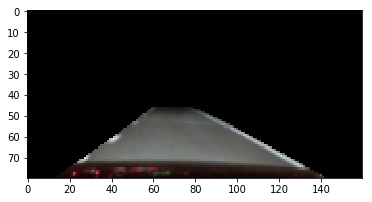

In [18]:
plt.imshow(show_lane(imgs[0], labels[0]))

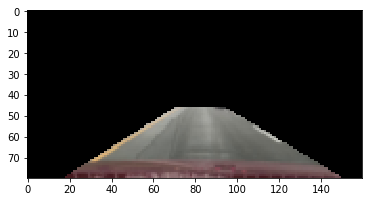

In [7]:
plt.imshow(show_lane(imgs[300], labels[300]))

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

In [19]:
import math

def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

def movingAverage(avg, new_sample, N=20):
    if (avg == 0):
        return new_sample
    avg -= avg / N;
    avg += new_sample / N;
    return avg;

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # state variables to keep track of most dominant segment
    largestLeftLineSize = 0
    largestRightLineSize = 0
    largestLeftLine = (0,0,0,0)
    largestRightLine = (0,0,0,0)

    if lines is None:
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            size = math.hypot(x2 - x1, y2 - y1)
            slope = ((y2-y1)/(x2-x1))
            # Filter slope based on incline and
            # find the most dominent segment based on length
            if (slope > 0.5): #right
                if (size > largestRightLineSize):
                    largestRightLine = (x1, y1, x2, y2)                    
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            elif (slope < -0.5): #left
                if (size > largestLeftLineSize):
                    largestLeftLine = (x1, y1, x2, y2)
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # Define an imaginary horizontal line in the center of the screen
    # and at the bottom of the image, to extrapolate determined segment
    imgHeight, imgWidth = (img.shape[0], img.shape[1])
    upLinePoint1 = np.array( [0, int(imgHeight - (imgHeight/3))] )
    upLinePoint2 = np.array( [int(imgWidth), int(imgHeight - (imgHeight/3))] )
    downLinePoint1 = np.array( [0, int(imgHeight)] )
    downLinePoint2 = np.array( [int(imgWidth), int(imgHeight)] )
    
    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p3 = np.array( [largestLeftLine[0], largestLeftLine[1]] )
    p4 = np.array( [largestLeftLine[2], largestLeftLine[3]] )
    upLeftPoint = seg_intersect(upLinePoint1,upLinePoint2, p3,p4)
    downLeftPoint = seg_intersect(downLinePoint1,downLinePoint2, p3,p4)
    if (math.isnan(upLeftPoint[0]) or math.isnan(downLeftPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upLeftPoint[0]), int(upLeftPoint[1])), (int(downLeftPoint[0]), int(downLeftPoint[1])), [0, 0, 255], 8) #draw left line

    # Calculate the average position of detected left lane over multiple video frames and draw
    global avgLeft
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    avgLeft = (movingAverage(avgx1, upLeftPoint[0]), movingAverage(avgy1, upLeftPoint[1]), movingAverage(avgx2, downLeftPoint[0]), movingAverage(avgy2, downLeftPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgLeft
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line

    # Find the intersection of dominant lane with an imaginary horizontal line
    # in the middle of the image and at the bottom of the image.
    p5 = np.array( [largestRightLine[0], largestRightLine[1]] )
    p6 = np.array( [largestRightLine[2], largestRightLine[3]] )
    upRightPoint = seg_intersect(upLinePoint1,upLinePoint2, p5,p6)
    downRightPoint = seg_intersect(downLinePoint1,downLinePoint2, p5,p6)
    if (math.isnan(upRightPoint[0]) or math.isnan(downRightPoint[0])):
        avgx1, avgy1, avgx2, avgy2 = avgLeft
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line
        avgx1, avgy1, avgx2, avgy2 = avgRight
        cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw right line
        return
    cv2.line(img, (int(upRightPoint[0]), int(upRightPoint[1])), (int(downRightPoint[0]), int(downRightPoint[1])), [0, 0, 255], 8) #draw left line

    # Calculate the average position of detected right lane over multiple video frames and draw
    global avgRight
    avgx1, avgy1, avgx2, avgy2 = avgRight
    avgRight = (movingAverage(avgx1, upRightPoint[0]), movingAverage(avgy1, upRightPoint[1]), movingAverage(avgx2, downRightPoint[0]), movingAverage(avgy2, downRightPoint[1]))
    avgx1, avgy1, avgx2, avgy2 = avgRight
    cv2.line(img, (int(avgx1), int(avgy1)), (int(avgx2), int(avgy2)), [255,255,255], 12) #draw left line

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    shapes = img.shape
    line_img = np.zeros((shapes[0], shapes[1] ,3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, alpha=0.8, beta=1., gamma=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, gamma)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

# run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os 

In [23]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
def process_image(image):

    # grayscale conversion before processing causes more harm than good
    # because sometimes the lane and road have same amount of luminance
    # grayscaleImage = grayscale(image)

    # Blur to avoid edges from noise
    blurredImage = gaussian_blur(image, 11)
    
    # Detect edges using canny
    # high to low threshold factor of 3
    # it is necessary to keep a linient threshold at the lower end
    # to continue to detect faded lane markings
    edgesImage = canny(blurredImage, 40, 50)
    
    # mark out the trapezium region of interest
    # dont' be too agressive as the car may drift laterally
    # while driving, hence ample space is still left on both sides.
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array( [[
                [3*width/4, 3*height/5],
                [width/4, 3*height/5],
                [40, height],
                [width - 40, height]
            ]], dtype=np.int32 )
    
    # mask the canny output with trapezium region of interest
    regionInterestImage = region_of_interest(edgesImage, vertices)
    
    # parameters tuned using this method:
    # threshold 30 by modifying it and seeing where slightly curved 
    # lane markings are barely detected
    # min line length 20 by modifying and seeing where broken short
    # lane markings are barely detected
    # max line gap as 100 to allow plenty of room for the algo to 
    # connect spaced out lane markings
    lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 40, 30, 200)
    
    # Test detected edges by uncommenting this
    # return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

    # draw output on top of original
    return weighted_img(lineMarkedImage, image)


# debug on images
inDirectory = "test_images"
outDirectory = inDirectory + "_out"
if not os.path.exists(outDirectory):
    os.makedirs(outDirectory)
imageNames = os.listdir(inDirectory + "/")
for imageName in imageNames:
    avgLeft = (0, 0, 0, 0)
    avgRight = (0, 0, 0, 0)
    image = mpimg.imread(inDirectory + "/" + imageName)
    out = process_image(image)
    mpimg.imsave(outDirectory + "/" + imageName, out)
    print("Processed " + outDirectory + "/" + imageName)
print("Processing complete.")

Processed test_images_out/DSC02670.JPG
Processed test_images_out/IMG_4921.jpg
Processed test_images_out/DSC02673.JPG
Processed test_images_out/solidYellowCurve.jpg
Processed test_images_out/solidWhiteRight.jpg
Processed test_images_out/IMG_4922.jpg
Processed test_images_out/whiteCarLaneSwitch.jpg
Processed test_images_out/solidWhiteCurve.jpg
Processed test_images_out/IMG_4920.jpg
Processed test_images_out/solidYellowCurve2.jpg
Processed test_images_out/IMG_4919.jpg
Processed test_images_out/DSC02668.JPG
Processed test_images_out/DSC02681.JPG
Processed test_images_out/solidYellowLeft.jpg
Processed test_images_out/trees1.jpg
Processed test_images_out/IMG_0022.jpg
Processed test_images_out/IMG_4923.jpg
Processed test_images_out/curvy1.jpg
Processed test_images_out/IMG_0023.jpg
Processed test_images_out/DSC02680.JPG
Processing complete.


In [77]:
# NOTE: The output you return should be a color image (3 channel) for processing video below
image = imgs[300]
# grayscale conversion before processing causes more harm than good
# because sometimes the lane and road have same amount of luminance
# grayscaleImage = grayscale(image)

# Blur to avoid edges from noise
blurredImage = gaussian_blur(image, 11)
    
# Detect edges using canny
# high to low threshold factor of 3
# it is necessary to keep a linient threshold at the lower end
# to continue to detect faded lane markings
edgesImage = canny(blurredImage, 40, 50)
    
# mark out the trapezium region of interest
# dont' be too agressive as the car may drift laterally
# while driving, hence ample space is still left on both sides.
height = image.shape[0]
width = image.shape[1]
vertices = np.array( [[
                [3*width/4, 3*height/5],
                [width/4, 3*height/5],
                [40, height],
                [width - 40, height]
            ]], dtype=np.int32 )
    
# mask the canny output with trapezium region of interest
regionInterestImage = region_of_interest(edgesImage, vertices)
    
# parameters tuned using this method:
# threshold 30 by modifying it and seeing where slightly curved 
# lane markings are barely detected
# min line length 20 by modifying and seeing where broken short
# lane markings are barely detected
# max line gap as 100 to allow plenty of room for the algo to 
# connect spaced out lane markings
lineMarkedImage = hough_lines(regionInterestImage, 1, np.pi/180, 30, 20, 200)
wi = weighted_img(lineMarkedImage, image)
# Test detected edges by uncommenting this
# return cv2.cvtColor(regionInterestImage, cv2.COLOR_GRAY2RGB)

# draw output on top of original


In [57]:
def linemark_convert(linemarkedimage):
    shapes = linemarkedimage.shape
    new_image = np.zeros((shapes[0], shapes[1], 1))
    for i in range(shapes[0]):
        for j in range(shapes[1]):
            if linemarkedimage[i][j].sum() > 0:
                
                new_image[i][j] = 1
    return new_image
                

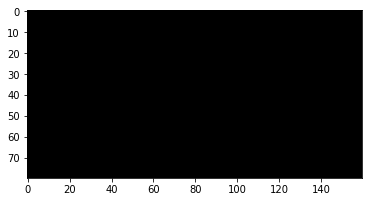

In [58]:
plt.imshow(show_lane(imgs[150], linemark_convert(lineMarkedImage)))

In [59]:
import sklearn

In [84]:
from sklearn import metrics

In [112]:
def accuracy_cv(img_number):
    line_marked = process_image(imgs[img_number])
    cm = metrics.confusion_matrix(labels[img_number].flatten(),linemark_convert(line_marked).flatten(), [0,1])
    return cm 
def accuracy_prec(img_number):
    line_marked = process_image(imgs[img_number])
    cm = metrics.precision_score(map(lambda x: x>0, labels[img_number].flatten()),
                                 map(lambda x: x>0, linemark_convert(line_marked).flatten()))
    return cm

In [120]:
acc_scores = map(accuracy_prec, range(len(imgs)))

In [122]:
np.mean(acc_scores)

0.1734071520643103

Let's try the one with the solid white lane on the right first ...

In [9]:
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 91.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 15.9 s, sys: 11.9 s, total: 27.7 s
Wall time: 2.74 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:07<00:00, 90.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 49.7 s, sys: 37 s, total: 1min 26s
Wall time: 7.88 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

1. I am not using grayscale image conversion, because in certain cases the lane line in yellow and the road in grey actually have the same brightness levels. I am seeing better results with edge detection on color images.
2. I am filtering the hough transform lines by checking their slope thresholds.
3. Once the lines are filtered, the most dominant line is found based on it's length for both left and right.
4. The start and end points of this dominant line are averaged for each video frame - with a moving average on the last 20 readings (one second will contain 24 frames generally, which gives us around 1sec of averaging.)
5. The algo would probably fail for sudden changes in the position of the car due to the moving average of 1 sec worth of data.
6. I have attempted the challenge below, kindly review it's output too.

Thanks!

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')

challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:05<00:00, 47.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 30.1 s, sys: 17.3 s, total: 47.4 s
Wall time: 5.81 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
###
# SELF VIDEO TEST
###


# reset global state of average values
avgLeft = (0, 0, 0, 0)
avgRight = (0, 0, 0, 0)

challenge_output = 'trees-out.mp4'
clip2 = VideoFileClip('trees.mp4')

# challenge_output = 'curvy-out.mp4'
# clip2 = VideoFileClip('curvy.mp4')


challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))